## Setup

In [704]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

def label_ovc(row): return 1 if (row.target_va - row.first_va) >= 0 else 0
df = pd.read_csv("~/Documents/Github/paper/input/df_3_years.csv")
df['outcome'] = df.apply(lambda row: label_ovc(row), axis=1)

X, y = df.drop(columns=['target_va', 'outcome']), df.outcome.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

def score(model, X, y, cv=5, scoring='accuracy'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return np.mean(scores), np.std(scores)

## Baseline

In [708]:
from sklearn.metrics import accuracy_score

def baseline_predictor(X):
    preds = []
    for i in range(len(X)):
        first, fourth = X.first_va.iloc[i], X.fourth_va.iloc[i]
        if (fourth-first) > 0: preds.append(1)
        else: preds.append(0)
    return preds

y_preds = np.array(baseline_predictor(X))
accuracy_score(y_preds, y)

0.7146529562982005

In [713]:
def baseline_predictor_2(X):
    preds = []
    average = np.mean(X.first_va)
    for i in range(len(X)):
        if X.first_va.iloc[i] <= average: preds.append(1)
        else: preds.append(0)
    return preds
        
y_preds = np.array(baseline_predictor_2(X))
accuracy_score(y_preds, y)

0.6401028277634961

## Logistic regression

In [531]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
score(lr, X, y)

(0.8611721611721611, 0.017079184215201108)

In [180]:
score(lr, X, y, scoring='roc_auc')

(0.9294671789890018, 0.023659731781872244)

In [168]:
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
confusion_matrix(y_test, y_preds)

array([[34,  6],
       [ 6, 32]])

In [178]:
accuracy_score(y_test, y_preds)

0.8461538461538461

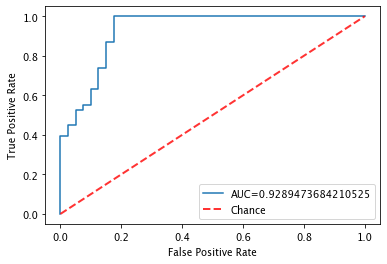

In [194]:
lr.fit(X_train, y_train)
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Random Forest

In [549]:
from sklearn.ensemble import RandomForestClassifier

#rf = RandomForestClassifier(random_state=42)
rf = RandomForestClassifier(max_depth=40, n_estimators=250, max_features=10,
                            min_samples_leaf=5, random_state=42)
score(rf, X, y)

(0.8252747252747252, 0.04308664015394174)

In [546]:
score(rf, X, y, scoring='roc_auc')

(0.8978017989105922, 0.020979605872922965)

In [151]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
score(rf, X, y)

(0.7995004995004995, 0.0057237323209765)

In [ ]:
params = {'max_depth': [6,9,20,50], 
         'n_estimators':[100,250,500,100], 
         'max_features': [2,4,6,10],
         'criterion' : ['gini', 'entropy'],
         'bootstrap':[True, False],
         'min_samples_leaf': [2, 5, 10]}

In [547]:
params = {'min_samples_leaf': [2, 5, 10]}

rf = RandomForestClassifier(max_depth=40, n_estimators=250, max_features=10,
                            random_state=42)

rnd_search = RandomizedSearchCV(rf, params, scoring='accuracy', 
                                n_iter = 10, cv = 5)
rnd_search.fit(X, y)
rnd_search.best_score_

0.8252747252747252

In [548]:
rnd_search.best_params_

{'min_samples_leaf': 5}

## Gradient Booster

In [123]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
score(gb, X, y)

(0.8047952047952048, 0.03691900068750318)

## MLP

In [124]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=200000, random_state=42)
score(mlp, X, y)

(0.7456210456210457, 0.04771412559330084)

In [126]:
from sklearn import ensemble
from sklearn import linear_model


models = {
 "rf": ensemble.RandomForestClassifier(n_estimators=50, 
                                       min_samples_leaf=15),
 "gb": ensemble.GradientBoostingClassifier(),
 "lr": linear_model.LogisticRegression()}

In [143]:
clf = models["gb"]
np.mean(cross_val_score(clf, X, y, scoring='accuracy'))

0.7944388944388944

In [144]:
score(clf, X, y)

(0.8046953046953046, 0.028135079698920873)

## MLP

In [340]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn as nn
import torch
from torch.autograd import Variable

ss = StandardScaler()

X_trans = ss.fit_transform(X)

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [350]:
train_data, test_data = [], []
for i in range(len(X_train)):
    train_data.append([X_train_tensors[i].to(torch.float32), 
                       y_train_tensors[i].type(torch.LongTensor)])
for i in range(len(X_test)):
    test_data.append([X_test_tensors[i].to(torch.float32), 
                       y_test_tensors[i].type(torch.LongTensor)])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, 
                                           batch_size=64, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=64)

# check shape
i1, l1 = next(iter(train_loader))
print(i1.shape)

torch.Size([64, 14])


In [351]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 2)
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(14)
        self.batchnorm2 = nn.BatchNorm1d(32)
    
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(self.batchnorm1(x))))
        x = self.dropout(torch.relu(self.fc2(self.batchnorm2(x))))    
        output = self.out(x)
        return output

In [352]:
m = nn.BatchNorm1d(100)
input = torch.randn(64, 100)
output = m(input)

In [353]:
data, label = next(iter(train_loader))
data = data[0]
data.shape

torch.Size([14])

In [354]:
model = Net()
model.eval()
output = model(data.unsqueeze(0))
output

tensor([[0.3021, 0.0611]], grad_fn=<AddmmBackward>)

In [355]:
def training_loop(n_epochs, optimiser, model, loss_fn, train_loader):
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train, loss_test = 0.0, 0.0
        for imgs, labels in train_loader:
            b_x = Variable(imgs)   # batch x
            b_y = Variable(labels)   # batch y
            outputs = model(imgs)
            loss = loss_fn(outputs, b_y)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            loss_train += loss.item() # .item() is used to escape gradient
        for imgs, labels in test_loader:
            b_x = Variable(imgs)
            b_y = Variable(labels)
            outputs = model(imgs)
            test_loss = loss_fn(outputs, b_y)
            loss_test += test_loss.item()
        accuracy = accuracy_score(test_loader)
        if epoch == 1 or epoch % (n_epochs/10) == 0:
            print("Epoch {}, Training Loss {}, Test Loss {}, Accuracy {}%".format(
                epoch,
                np.round(loss_train / len(train_loader), 4),
                np.round(loss_test / len(test_loader), 4),
                np.round(accuracy*100, 2)))
            
def accuracy_score(val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad(): # we don't want gradients here
        for imgs, labels in val_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
        return correct/total

In [356]:
model = Net()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=1000,
    optimiser=optimiser,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Epoch 1, Training Loss 0.6925, Test Loss 0.66, Accuracy 69.23%
Epoch 100, Training Loss 0.0615, Test Loss 1.0045, Accuracy 82.05%
Epoch 200, Training Loss 0.0222, Test Loss 1.4515, Accuracy 82.05%
Epoch 300, Training Loss 0.0057, Test Loss 2.1532, Accuracy 79.49%
Epoch 400, Training Loss 0.0014, Test Loss 2.7197, Accuracy 82.05%
Epoch 500, Training Loss 0.0006, Test Loss 3.0518, Accuracy 82.05%
Epoch 600, Training Loss 0.0003, Test Loss 3.2749, Accuracy 82.05%
Epoch 700, Training Loss 0.0002, Test Loss 3.4662, Accuracy 82.05%
Epoch 800, Training Loss 0.0001, Test Loss 3.628, Accuracy 82.05%
Epoch 900, Training Loss 0.0001, Test Loss 3.7699, Accuracy 82.05%
Epoch 1000, Training Loss 0.0001, Test Loss 3.9036, Accuracy 82.05%


In [357]:
def validate(model, train_loader, val_loader):
    model.eval()
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct, total = 0, 0
        with torch.no_grad(): # we don't want gradients here
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            print("Accuracy {}: {:.2f}".format(name, correct/total))

In [358]:
validate(model, train_loader, test_loader)

Accuracy train: 1.00
Accuracy val: 0.82


### k-fold cross validation

In [692]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F

In [693]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 2)
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(14)
        self.batchnorm2 = nn.BatchNorm1d(32)
    
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(self.batchnorm1(x))))
        x = self.dropout(torch.relu(self.fc2(self.batchnorm2(x))))    
        output = self.out(x)
        return output

In [694]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=4, padding=2)
        self.conv2 = nn.Conv1d(in_channels=5, out_channels=2, kernel_size=4, padding=2)
        self.layer1 = nn.Sequential(self.conv1, nn.ReLU())
        self.layer2 = nn.Sequential(self.conv2, nn.ReLU())         
        # fully connected layer, output 2 classes
        self.layer3 = nn.Sequential(nn.Linear(32, 64), nn.ReLU(),
                                    nn.Linear(64, 16), nn.ReLU(),
                                    nn.Linear(16, 8), nn.ReLU())
        self.out = nn.Linear(8, 2)
    
    def forward(self, x):
        x = self.layer1(x.unsqueeze(1))
        x = self.layer2(x)
        # flatten the output of conv2 to (batch_size, 32)
        x = x.view(x.size(0), -1) 
        x = self.layer3(x)
        output = self.out(x)
        return output

In [695]:
data, label = next(iter(train_loader))
data = data[0]
data.unsqueeze(0).shape

torch.Size([1, 14])

In [696]:
model = Net()
model.eval()
output = model(data.unsqueeze(0))
output

tensor([[-0.2252, -0.0288]], grad_fn=<AddmmBackward>)

In [697]:
class PytorchKfolds:
    
    def __init__(self, n_epochs=30):
        self.df = self.init_df()
        self.kdf = self.create_folds(self.df)
        self.n_epochs = n_epochs
        self.loss_fn = nn.CrossEntropyLoss()

    def init_df(self):
        def label_ovc(row): return 1 if (row.target_va - row.first_va) >= 0 else 0
        df = pd.read_csv("~/Documents/Github/paper/input/df_3_years.csv")
        df['outcome'] = df.apply(lambda row: label_ovc(row), axis=1)
        return df
    
    def create_folds(self, df):
        # we create a new column called kfold and fill it with -1
        df["kfold"] = -1
        # the next step is to randomize the rows of the data
        df = df.sample(frac=1).reset_index(drop=True)
        # fetch labels
        y = df.outcome.values
        # initiate the kfold class from model_selection module
        kf = model_selection.StratifiedKFold(n_splits=5)
        # fill the new kfold column
        for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
            df.loc[v_, 'kfold'] = f
        return df
    
    def inputs_targets(self, df, fold):
        df = create_folds(df)
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_train.fillna(df_train.mean(), inplace=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)
        df_valid.fillna(df_valid.mean(), inplace=True)
        X_train = df_train.drop(columns=["target_va", "outcome", "kfold"]).values
        y_train = df_train.outcome.values
        X_valid = df_valid.drop(columns=["target_va", "outcome", "kfold"]).values
        y_valid = df_valid.outcome.values
        return X_train, X_valid, y_train, y_valid
    
    def train_test_kfold(self, df, fold):
        X_train, X_test, y_train, y_test = self.inputs_targets(df, fold)
        # scale the data
        ss = StandardScaler()
        X_train, X_test = ss.fit_transform(X_train), ss.fit_transform(X_test)
        # convert to tensors
        X_train_tensors = Variable(torch.Tensor(X_train))
        X_test_tensors = Variable(torch.Tensor(X_test))
        y_train_tensors = Variable(torch.Tensor(y_train))
        y_test_tensors = Variable(torch.Tensor(y_test))
        return X_train_tensors, X_test_tensors, y_train_tensors, y_test_tensors
    
    def create_dataloaders(self, X_train, X_test, y_train, y_test):
        train_data, test_data = [], []
        for i in range(len(X_train)):
            train_data.append([X_train[i].to(torch.float32), 
                               y_train[i].type(torch.LongTensor)])
        for i in range(len(X_test)):
            test_data.append([X_test[i].to(torch.float32), 
                               y_test[i].type(torch.LongTensor)])
        train_loader = torch.utils.data.DataLoader(train_data, shuffle=False, 
                                               batch_size=64, drop_last=True)
        test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, 
                                                  batch_size=len(X_test))
        return train_loader, test_loader
    
    def reset_weights(self, m):
        for layer in m.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
    
    def accuracy_score(self, val_loader, model):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad(): # we don't want gradients here
            for imgs, labels in val_loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            return correct/total
        
    def auc_score(self, val_loader, model):
        model.eval()
        aucs = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                outputs = model(imgs).detach().numpy()[::, 1]
                labels = labels.detach().numpy()
                aucs.append(roc_auc_score(labels, outputs))
            return np.round(np.mean(aucs), 4)
                
    
    def training_loop(self, train_loader, val_loader, verbose=0):
        n_epochs=self.n_epochs
        model=Net()
        model.apply(reset_weights)
        optimiser=torch.optim.Adam(model.parameters(), lr=1e-2)
        loss_fn=self.loss_fn
        model.train()
        for epoch in range(1, n_epochs + 1):
            loss_train, loss_test = 0.0, 0.0
            for imgs, labels in train_loader:
                b_x = Variable(imgs)   # batch x
                b_y = Variable(labels)   # batch y
                outputs = model(imgs)
                loss = loss_fn(outputs, b_y)
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                loss_train += loss.item() # .item() is used to escape gradient
            accuracy = self.accuracy_score(val_loader, model)
            if (epoch == 1 or epoch % (n_epochs/10) == 0) and verbose>0:
                print("Epoch {}, Training Loss {}, Accuracy {}%".format(
                    epoch,
                    np.round(loss_train / len(train_loader), 4),
                    np.round(accuracy*100, 2)))
        train_accuracy = self.accuracy_score(train_loader, model)
        test_accuracy = self.accuracy_score(val_loader, model)
        test_auc = self.auc_score(val_loader, model)
        if verbose==1:
            print(f"Train accuracy = {train_accuracy*100}%, validation accuracy = {test_accuracy*100}%")
            print(f"Test ROC AUC = {test_auc}")
        return train_accuracy, test_accuracy, test_auc
                
    def kfold_train(self, verbose=0):
        tr_a, te_a, te_auc = [], [], []
        for i in range(5):
            if verbose > 0: print(f'FOLD {i}')
            X_train, X_test, y_train, y_test = self.train_test_kfold(self.kdf, i)
            train_loader, val_loader = self.create_dataloaders(X_train, X_test, y_train, y_test)
            train_acc, test_acc, test_auc = self.training_loop(train_loader=train_loader, 
                                                     val_loader=val_loader, verbose=verbose)
            tr_a.append(np.round(train_acc, 2))
            te_a.append(np.round(test_acc, 2))
            te_auc.append(np.round(test_auc, 2))
            if verbose > 0: print('--------------------------------')
        if verbose!=-1:
            print("FINAL RESULTS")
            print(f"Mean training accuracy: {round(np.mean(tr_a), 2)} (+/- {round(np.std(tr_a), 2)})")
            print(f"Mean validation accuracy: {round(np.mean(te_a), 2)} (+/- {round(np.std(te_a), 2)})")
            print(f"Mean validation ROC AUC: {round(np.mean(te_auc), 2)} (+/- {round(np.std(te_auc), 2)})")
        if verbose==-1: return np.mean(te_auc)

In [698]:
ete = PytorchKfolds(n_epochs=40)
ete.kfold_train()

FINAL RESULTS
Mean training accuracy: 0.95 (+/- 0.01)
Mean validation accuracy: 0.82 (+/- 0.03)
Mean validation ROC AUC: 0.88 (+/- 0.04)


In [634]:
def epoch_search(start, stop, step):
    best_auc, best_epoch = 0.0, 0
    for i in range(start, stop, step):
        ete = PytorchKfolds(n_epochs=i)
        auc = ete.kfold_train(verbose=-1)
        if auc > best_auc:
            best_auc = auc
            best_epoch = i
    return best_auc, best_epoch

In [635]:
epoch_search(5, 100, 10)

(0.89, 65)

## TabNet

In [670]:
from pytorch_tabnet.tab_model import TabNetClassifier
import sklearn

def label_ovc(row): return 1 if (row.target_va - row.first_va) >= 0 else 0
df = pd.read_csv("~/Documents/Github/paper/input/df_3_years.csv")
df['outcome'] = df.apply(lambda row: label_ovc(row), axis=1)

X, y = df.drop(columns=['target_va', 'outcome']).values, df.outcome.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "verbose":0,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params) 
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)],
        eval_metric=['accuracy'], patience=100,
        max_epochs=1000)


Early stopping occurred at epoch 313 with best_epoch = 213 and best_val_0_accuracy = 0.91026
Best weights from best epoch are automatically used!


In [671]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
test_auc

0.9215557020435069

In [672]:
preds = clf.predict(X_test)
sklearn.metrics.accuracy_score(y_test, preds)

0.9102564102564102

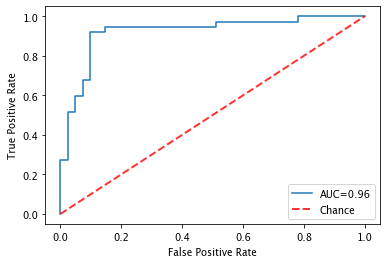

In [691]:
import os 
os.chdir ('/Users/charlesoneill/Documents/GitHub/paper/results')

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
auc = np.round(auc+0.04, 2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig("tabnet_year3_auc.png", dpi=250)
plt.show()